In [1]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import Tuple


In [2]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                



In [3]:
# Test code
#     return means, stdevs
# Scalar Multiply
asc = np.multiply(2,[1,2,3])
asc

# Vector sum
asd = [1, 2] + [3, 4] + [5, 6] + [7, 8]
assd = np.sum([[1, 2], [3, 4], [5, 6], [7, 8]],axis=0)
assd

# # Standard deviation                        
# def standard_deviation(xs: List[float]) -> float:
#     """The standard deviation is the square root of the variance"""
#     return math.sqrt(variance(xs)) 

array([16, 20])

In [4]:
# Orginal dataset
data_org = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]
# Data Frame
data = pd.DataFrame(data_org)

In [5]:
# xs = [(1,) + row[:2] for row in data_org]
# ys = [row[2] for row in data_org]

# Maximum values
exp_val = data.iloc[:,0]
sal_val = data.iloc[:,1]

dd = data.iloc[:,0:2]

data_list = []
for i in range(len(data)):
    data_exp = data.loc[i,0]
    data_sal = data.loc[i,1]
    data_set = [1,data_exp,data_sal]
    data_list.append(data_set)
#     print(dd.iloc[i,0:2])
xs = data_list
ys = data.iloc[:,2].tolist()


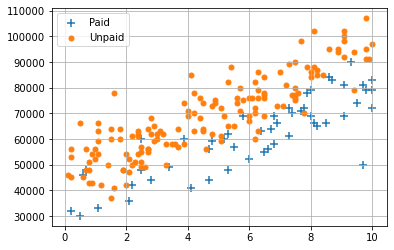

In [6]:
# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]

# y = target values, last column of the data frame
y = data.iloc[:, -1]

# filter out the applicants that got admitted
paid = data.loc[y == 1]

# filter out the applicants that din't get admission
unpaid = data.loc[y == 0]

# plots
# msize = []
# for n in range(len([paid])):
#     msize.append(100)
    
plt.scatter(paid.iloc[:, 0], paid.iloc[:, 1], s=50, marker = '+', label='Paid')
plt.scatter(unpaid.iloc[:, 0], unpaid.iloc[:, 1], s=25, marker = 'o', label='Unpaid')
plt.legend()
plt.grid()

# Show Plots
plt.show()



In [7]:
# X1 = [np.ones((X.shape[0], 1)), X]
# X = np.c_[np.ones((X.shape[0], 1)), X]
# y = y[:, np.newaxis]
# X = pd.DataFrame(np.c_[np.ones((X.shape[0], 1)), X])


# x_ones = pd.DataFrame(np.ones((X.shape[0], 1)))
# xl = pd.concat([x_ones,X])
# # x1 = pd.Series(xl)
# x1[1:]

In [8]:
asd = np.dot([1, 2, 3], [4, 5, 6])
asd
len(xs)

200

In [9]:
mm,nn = scale(xs)
# dim = len(xs[1])
# dim

mm

# rescaled_xs = rescale(xs)
# rescaled_xs
# beta = least_squares_fit(rescaled_xs, ys, 0.001, 500, 1)
# predictions = [predict(x_i, beta) for x_i in rescaled_xs]
meansx = vector_mean(xs)
std = standard_deviation(xs)
std

array([22290.12781755, 22286.11996681, 47206.34316742])

In [10]:
rescale(xs)

[[1, -1.509461466111811, -1.2035820048365877],
 [1, -1.0880203866948326, -1.2035820048365877],
 [1, -0.8772998469863432, -0.4312299161713978],
 [1, -0.28025831781229016, -0.23814189400510025],
 [1, 0.3519033013131777, 0.5985728687155223],
 [1, 0.527503751070252, 0.14803415032749476],
 [1, 0.878704650584401, 0.5985728687155223],
 [1, 1.0894251902928902, 1.3709249573807123],
 [1, 1.3001457300013792, 1.0491115871035497],
 [1, 1.756706899369773, 1.0491115871035497],
 [1, -1.4743413761603963, -1.5253953751137503],
 [1, -1.1231404766462474, -0.4312299161713978],
 [1, 1.756706899369773, 0.7916608908818198],
 [1, 0.38702339126459245, 0.5985728687155223],
 [1, -1.263620836451907, -1.0748566567257227],
 [1, 1.4406260898070389, 1.6283756536024423],
 [1, 0.2816631214103478, 0.5342101946600898],
 [1, 0.07094258170185867, 0.14803415032749476],
 [1, -1.4041011962575665, -0.6886806123931277],
 [1, 0.3519033013131777, 0.019308802216629752],
 [1, -0.03441768815238591, 0.4698475206046573],
 [1, 0.4923836

In [11]:
rescaled_xs = rescale(xs)
beta = least_squares_fit(rescaled_xs, ys, 0.001, 1000, 1)
predictions = [predict(x_i, beta) for x_i in rescaled_xs]

least squares fit: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.78it/s]


In [12]:
# rescaled = [v[:] for v in xs]
# rescaled

# means,stdevs = scale(xs)
# print(means)

# # for i in range(dim):
# #     print(i)

# vv = []
# vv0 = []
# for v in xs:
#     if stdevs[i] > 0:
#         v1 = np.array(v[1:3])
#         v_means = np.array(means[1:3])
#         v0 = (np.array(v[1:3]) - np.array(means[1:3]))/np.array(stdevs[1:3])
#         print(v0)
# #     vv1 = v1
# #     print(v_means)
# #     for i in range(dim):
# #         if stdevs[i] > 0:
# #             v1[i] = (v1[i] - means[i]) / stdevs[i]
# #             vv.append(v1[i])
  
# # vv0


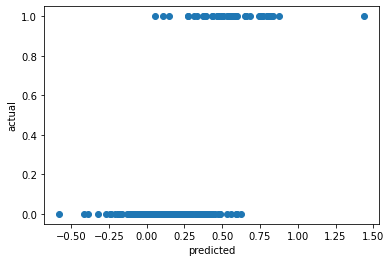

In [13]:
plt.scatter(predictions, ys)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

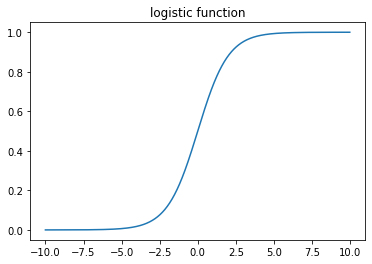

In [14]:
z = [zi/50 - 10 for zi in range(1000)]
plt.plot(z, [logistic(zi) for zi in z])
plt.title('logistic function')
plt.show()

In [15]:
random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_xs, ys, 0.33)

learning_rate = 0.01

# pick a random starting point
beta = [random.random() for _ in range(3)]

with tqdm.trange(5000) as t:
    for epoch in t:
        gradient = negative_log_gradient(x_train, y_train, beta)
        beta = gradient_step(beta, gradient, -learning_rate)
        loss = negative_log_likelihood(x_train, y_train, beta)
        t.set_description(f"loss: {loss:.3f} beta: {beta}")


loss: 39.963 beta: [-2.02390325  4.69304785 -4.46981132]: 100%|███████████████████| 5000/5000 [00:34<00:00, 143.37it/s]


In [16]:
beta

array([-2.02390325,  4.69304785, -4.46981132])

In [17]:
means, stdevs = scale(xs)
beta_unscaled = [(beta[0] - beta[1] * means[1] / stdevs[1] - beta[2] * means[2] / stdevs[2]),
                 beta[1] / stdevs[1],
                 beta[2] / stdevs[2]]
beta_unscaled

[8.927236932527311, 1.6482026277676038, -0.00028768900920142336]

In [18]:
true_positives = false_positives = true_negatives = false_negatives = 0

for x_i, y_i in zip(x_test, y_test):
    prediction = logistic(dot(beta, x_i))

    if y_i == 1 and prediction >= 0.5:  # TP: paid and we predict paid
        true_positives += 1
    elif y_i == 1:                      # FN: paid and we predict unpaid
        false_negatives += 1
    elif prediction >= 0.5:             # FP: unpaid and we predict paid
        false_positives += 1
    else:                               # TN: unpaid and we predict unpaid
        true_negatives += 1

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)


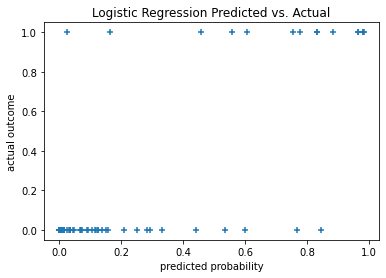

In [19]:
predictions = [logistic(dot(beta, x_i)) for x_i in x_test]
plt.scatter(predictions, y_test, marker='+')
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()

In [20]:
mu_1 = np.mean([xi[1] for xi in xs])
sig_1 = standard_deviation([xi[1] for xi in xs])

mu_2 = np.mean([xi[2] for xi in xs])
sig_2 = standard_deviation([xi[2] for xi in xs])

In [21]:
# beta_hat = beta

In [22]:
# beta_hat_unscaled[0] = beta_hat[0] - (beta_hat[1]*mu_1)/sig_1 - (beta_hat[2]*mu_2)/sig_2
# beta_hat_unscaled[0]

In [23]:
# beta_hat_unscaled[1] = beta_hat[1]/sig_1
# beta_hat_unscaled[1]

In [24]:
# beta_hat_unscaled[2] = beta_hat[2]/sig_2
# beta_hat_unscaled[2]

In [25]:
# # min_range = (data_marks.min())
# # min_range = math.floor(min_range[0])
# # max_range = (data_marks.max())
# # max_range = math.ceil(max_range[0])

# min_val = math.floor(np.min(exp_val))
# max_val = math.ceil(np.max(exp_val))

# pay_avg = (min(unpaid.iloc[:, 1]) + min(unpaid.iloc[:,1]))/2
# pay_avg

# # x_db = [xi for xi in range(min_val,max_val)]
# x_db = np.linspace(min_val,max_val,len(exp_val))
# y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#         for xi in x_db]
# y_db_1 = [-((beta_unscaled[0]*xi**2)/beta_unscaled[2] - (beta_unscaled[1]*xi)/beta_unscaled[2] - beta_unscaled[0]/beta_unscaled[2])/10
#         for xi in x_db]
# y_db_0 = []
# for m in range(len(x_db)):
#     y_db_0.append(y_db_1[m] + 37000)
   


In [26]:
# min_range = (data_marks.min())
# min_range = math.floor(min_range[0])
# max_range = (data_marks.max())
# max_range = math.ceil(max_range[0])

min_val = math.floor(np.min(exp_val))
max_val = math.ceil(np.max(exp_val))

pay_avg_paid = (min(paid.iloc[:, 1]) + max(paid.iloc[:,1]))
pay_avg_unpaid = (min(unpaid.iloc[:, 1]) + max(unpaid.iloc[:,1]))
pay_avg = (pay_avg_paid + pay_avg_unpaid)/(2*paid.shape[1])


# x_db = [xi for xi in range(min_val,max_val)]
x_db = np.linspace(min_val,max_val,len(exp_val))
y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
        for xi in x_db]
y_db_1 = [-((beta_unscaled[1]/beta_unscaled[2])*(xi**3) -(beta_unscaled[1]/beta_unscaled[2])*(xi**2)- (beta_unscaled[1]/beta_unscaled[2])*xi - (beta_unscaled[0]/beta_unscaled[2]))*0.01
        for xi in x_db]
y_db_1b = [-((beta_unscaled[1]/beta_unscaled[2])*(xi**2)- (beta_unscaled[1]/beta_unscaled[2])*xi - (beta_unscaled[0]/beta_unscaled[2]))*0.1
        for xi in x_db]
y_db_0 = []
for m in range(len(x_db)):
    y_db_0.append(y_db_1b[m] + pay_avg)
    
pay_avg
paid.shape

(52, 3)

In [27]:
# # min_range = (data_marks.min())
# # min_range = math.floor(min_range[0])
# # max_range = (data_marks.max())
# # max_range = math.ceil(max_range[0])

# min_val = math.floor(np.min(exp_val))
# # max_val = math.ceil(np.max(exp_val))

# pay_avg_paid = (min(paid.iloc[:, 1]) + max(paid.iloc[:,1]))
# pay_avg_unpaid = (min(unpaid.iloc[:, 1]) + max(unpaid.iloc[:,1]))
# pay_avg = (pay_avg_paid + pay_avg_unpaid)/(2*paid.shape[1])


# # x_db = [xi for xi in range(min_val,max_val)]
# x_db = np.linspace(min_val,max_val,len(exp_val))
# y_db = [(-beta_unscaled[1]/beta_unscaled[2]*xi - beta_unscaled[0]/beta_unscaled[2])
#         for xi in x_db]
# y_db_1 = [((beta_unscaled[1]/beta_unscaled[2])*xi**2 + (beta_unscaled[1]/beta_unscaled[2])*xi + beta_unscaled[0]/beta_unscaled[2])*0.1
#         for xi in x_db]
# y_db_0 = []
# for m in range(len(x_db)):
#     y_db_0.append(y_db_1[m] - pay_avg)
    
# pay_avg
# paid.shape

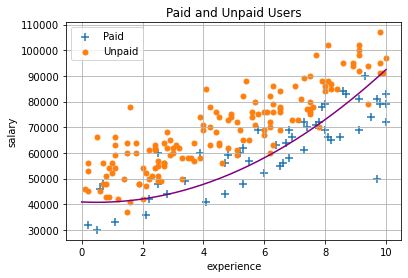

In [28]:
plt.scatter(paid.iloc[:, 0], paid.iloc[:, 1], s=50, marker = '+', label='Paid')
plt.scatter(unpaid.iloc[:, 0], unpaid.iloc[:, 1], s=25, marker = 'o', label='Unpaid')
plt.plot(x_db, y_db_0, 'purple')
plt.xlabel('experience')
plt.ylabel('salary')
plt.legend()
plt.grid()
plt.title('Paid and Unpaid Users')
plt.show()

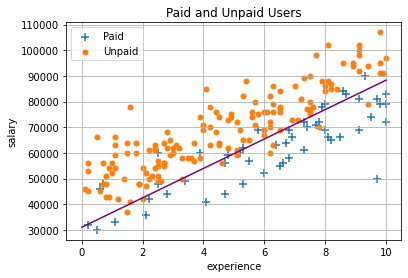

In [29]:
plt.scatter(paid.iloc[:, 0], paid.iloc[:, 1], s=50, marker = '+', label='Paid')
plt.scatter(unpaid.iloc[:, 0], unpaid.iloc[:, 1], s=25, marker = 'o', label='Unpaid')
plt.plot(x_db, y_db, 'purple')
plt.xlabel('experience')
plt.ylabel('salary')
plt.legend()
plt.grid()
plt.title('Paid and Unpaid Users')
plt.show()

In [30]:
# rescale(xs)